In [14]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.distributions
import torch.optim as optim
from torch import nn 
from torch.autograd import Variable

import torchtext
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe

In [15]:
class Model(torch.nn.Module):
    def __init__(self, batch_size, num_classes, mlp_out_size, vocab_size, embedding_length, weights, num_layers, hidden_size = 100, biDirectional = False):
        super(Model, self).__init__() 
        """
        Arguments
        ---------
        batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
        num_classes : 28 = (For full classification)
        hidden_sie : Size of the hidden_state of the LSTM   (// Later BiLSTM)
        vocab_size : Size of the vocabulary containing unique words
        embedding_length : Embeddding dimension of GloVe word embeddings
        weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table 
        --------

        """

        self.batch_size = batch_size
        self.num_classes = num_classes
        self.vocab_size = vocab_size
        self.embedding_length = embedding_length
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.mlp_out_size = mlp_out_size
        self.biDirectional = biDirectional

        self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
        self.word_embeddings.weights = nn.Parameter(weights, requires_grad=False)
        
        self.lstm_layer = LSTM(self.batch_size, self.hidden_size, self.embedding_length, self.biDirectional, self.num_layers)

        if(self.biDirectional):
            self.mlp = MLP(self.hidden_size*2, self.mlp_out_size, self.num_classes)
#             self.FF = nn.Linear(self.hidden_size*2, num_classes)
        else:
            self.mlp = MLP(self.hidden_size, self.mlp_out_size, self.num_classes)
#             self.FF = nn.Linear(self.hidden_size, self.num_classes)

    def forward(self, input_sequence):
        input_ = self.word_embeddings(input_sequence)
        out_lstm, final_hidden_state = self.lstm_layer(input_)
        if self.biDirectional:
            final_hidden_state = final_hidden_state.view(self.num_layers, 2, input_.shape[0], self.hidden_size) # num_layer x num_dir x batch x hidden
            final_hidden_state = final_hidden_state[-1]
            final_hidden_state = final_hidden_state.transpose(0,1).reshape(input_.shape[0], self.hidden_size*2)
        else:
            final_hidden_state = final_hidden_state[-1]
        
        mlp_output = self.mlp(final_hidden_state)
#         ff_output = self.FF(mlp_output)
#         print("FF out size: ", ff_output.shape)
        predictions = torch.softmax(mlp_output, dim = -1)
        return predictions

In [16]:
class LSTM(torch.nn.Module):
    """
        Arguments
        ---------
        batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
        hidden_size : Size of the hidden_state of the LSTM   (* Later BiLSTM, check dims for BiLSTM *)
        embedding_length : Embeddding dimension of GloVe word embeddings
        --------
    """
    def __init__(self, batch_size, hidden_size, embedding_length, biDirectional = False, num_layers = 2):

        super(LSTM, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.embedding_length = embedding_length
        self.biDirectional= biDirectional
        self.num_layers = num_layers

        self.lstm = nn.LSTM(self.embedding_length, self.hidden_size, bidirectional = self.biDirectional, batch_first = True, num_layers = self.num_layers)   # Dropout  

    def forward(self, input_sequence, batch_size=None):
        out_lstm, (final_hidden_state, final_cell_state) = self.lstm(input_sequence)   # ouput dim: ( batch_size x seq_len x hidden_size )
        return out_lstm, final_hidden_state

In [17]:
# If want to add extra MLP Layer
class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim, num_classes):
        super(MLP, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_classes = num_classes

        self.ff_1 = nn.Linear(self.input_dim, self.output_dim)
        self.relu = nn.ReLU()
        self.ff_2 = nn.Linear(self.output_dim, self.num_classes)
#         self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        out_1 = self.ff_1(x)
        out_relu = self.relu(out_1)
        out_2 = self.ff_2(out_relu)
#         out_sigmoid = self.sigmoid(out_2)

        return out_2

In [18]:
def clip_gradient(model, clip_value):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)

In [37]:
def train_model(model, optim, train_iter, epoch, batch_size, num_classes):
    total_epoch_loss = 0
    total_epoch_acc = 0
    
    steps = 0
    model.train()
    for idx, batch in enumerate(train_iter):
        text = batch.text[0]
        target = batch.labels
        target = torch.autograd.Variable(target).long()
        if torch.cuda.is_available():
            text = text.cuda()
            target = target.cuda()
        if (text.size()[0] is not batch_size): # One of the batch returned by BucketIterator has length different than 32.
            continue
        optim.zero_grad()
        prediction = model(text)
        print(prediction.shape)
        print(prediction)
        print(target.shape)
        print(target)
        loss =  loss_fn(prediction, target)
#         if math.isnan(loss.item()):
#             print(prediction, target)

        num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).sum()
        acc = 100.0 * num_corrects/len(batch)
        loss.backward()
        clip_gradient(model, 1e-1)
        optim.step()
        steps += 1
        
        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()
        
    return total_epoch_loss/len(train_iter), total_epoch_acc/len(train_iter)

In [20]:
def eval_model(model, val_iter, num_classes):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(val_iter):
            text = batch.text[0]
            if (text.size()[0] is not 16):
                continue
            target = batch.labels
            target = torch.autograd.Variable(target).long()
            if torch.cuda.is_available():
                text = text.cuda()
                target = target.cuda()
            prediction = model(text)
            # Sanity check
            # print("Test Prediction: ", prediction)
            # Defualt - Cross entropy loss funtion
            loss =  loss_fn(prediction, target)
            
            if math.isnan(loss.item()):
                print(prediction, target)
            
            num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).sum()
            acc = 100.0 * num_corrects/len(batch)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()
            
    return total_epoch_loss/len(val_iter), total_epoch_acc/len(val_iter)

<>:8: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:8: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-20-654a9e92e13f>:8: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if (text.size()[0] is not 16):


In [21]:
def load_data(batch_size= 16, embedding_length = 100):
    tokenize = lambda x: x.split()
    TEXT = data.Field(sequential=True, tokenize=tokenize, lower=True, include_lengths=True, batch_first=True, fix_length=30)
    LABELS = data.LabelField(batch_first=True, dtype=torch.float)

    train, val, test = data.TabularDataset.splits(
      path='/Users/prakruti/Documents/GoEmotions-classification/data/multi_class_data/', train='train.tsv',
      validation='dev.tsv', test='test.tsv', format='tsv',
      fields=[('text', TEXT), ('labels', LABELS)])
    
    train_iter, val_iter, test_iter = data.BucketIterator.splits(
      (train, val, test), batch_sizes=(16, 16, 16), sort_key=lambda x: len(x.text), device=0)

    # build the vocabulary
    TEXT.build_vocab(train, vectors=GloVe(name='6B', dim=embedding_length))
    LABELS.build_vocab(train)
    print(LABELS.vocab.__dict__)

    word_embeddings = TEXT.vocab.vectors
    vocab_size = len(TEXT.vocab)

    return TEXT, vocab_size, word_embeddings, train_iter, val_iter, test_iter

In [22]:
# def vectorize(x):
#     if x == '':
#         return 5
#     else:
#         x = float(x)
#         return int(x)

In [38]:
TEXT, vocab_size, word_embeddings, train_iter, valid_iter, test_iter = load_data()

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


{'freqs': Counter({'27': 14219, '0': 4130, '4': 2939, '15': 2662, '3': 2470, '1': 2328, '7': 2191, '18': 2086, '10': 2022, '20': 1581, '2': 1567, '17': 1452, '6': 1368, '25': 1326, '9': 1269, '22': 1110, '5': 1087, '26': 1060, '13': 853, '11': 793, '8': 641, '14': 596, '24': 545, '12': 303, '19': 164, '23': 153, '21': 111, '16': 77}), 'itos': ['27', '0', '4', '15', '3', '1', '7', '18', '10', '20', '2', '17', '6', '25', '9', '22', '5', '26', '13', '11', '8', '14', '24', '12', '19', '23', '21', '16'], 'unk_index': None, 'stoi': defaultdict(None, {'27': 0, '0': 1, '4': 2, '15': 3, '3': 4, '1': 5, '7': 6, '18': 7, '10': 8, '20': 9, '2': 10, '17': 11, '6': 12, '25': 13, '9': 14, '22': 15, '5': 16, '26': 17, '13': 18, '11': 19, '8': 20, '14': 21, '24': 22, '12': 23, '19': 24, '23': 25, '21': 26, '16': 27}), 'vectors': None}


In [24]:
# next(iter(train_iter))

In [22]:
# next(iter(test_iter))

In [35]:
# next(iter(valid_iter))


[torchtext.data.batch.Batch of size 16]
	[.text]:('[torch.LongTensor of size 16x30]', '[torch.LongTensor of size 16]')
	[.labels]:[torch.FloatTensor of size 16]

In [39]:
# Cross entropy loss
loss_fn = F.cross_entropy

learning_rate = 2e-5
batch_size = 16
embedding_length = 100
num_classes = 28
mlp_out_size = 64
weights = word_embeddings
hidden_size = 100
num_layers = 3

model = Model(batch_size, num_classes, mlp_out_size, vocab_size, embedding_length, weights, num_layers, hidden_size, biDirectional=False)
optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))

In [40]:
num_bad_epochs = 0
epoch = 0
least_loss = float('inf')
training_stats = pd.DataFrame(columns=['Epoch', 'Train_Loss', 'Train_Acc', 'Val_Loss', 'Val_Acc'])

while(True):
    print("Epoch", epoch)
    train_loss, train_acc = train_model(model, optim, train_iter, epoch, batch_size, num_classes)
    val_loss, val_acc = eval_model(model, valid_iter, num_classes) 
    print(f'Epoch: {epoch+1:02}')
    if val_loss < least_loss:
        least_loss = val_loss
        num_bad_epochs = 0
        print("*** Least validation loss")
        torch.save(model.state_dict(), "LSTM_MLP_3L_28")
    else:
        num_bad_epochs += 1
#     print(f'Epoch: {epoch+1:2}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%')
    print(f'Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%') 
    print(f'Val Loss: {val_loss:3f}, Val Acc: {val_acc:.2f}%')
    print("-------------")
    
    training_stats = training_stats.append(
        pd.Series([epoch+1, train_loss, train_acc, val_loss, val_acc], index=training_stats.columns), 
        ignore_index=True)
    if num_bad_epochs >= 8:
        break
        
    epoch += 1
    if epoch == 50:
        break

Epoch 0
torch.Size([16, 28])
tensor([[0.0370, 0.0375, 0.0384, 0.0389, 0.0369, 0.0345, 0.0367, 0.0323, 0.0354,
         0.0318, 0.0387, 0.0347, 0.0383, 0.0338, 0.0351, 0.0378, 0.0308, 0.0387,
         0.0361, 0.0343, 0.0347, 0.0384, 0.0388, 0.0321, 0.0315, 0.0315, 0.0383,
         0.0370],
        [0.0371, 0.0374, 0.0383, 0.0389, 0.0370, 0.0343, 0.0367, 0.0323, 0.0353,
         0.0318, 0.0387, 0.0347, 0.0383, 0.0337, 0.0350, 0.0378, 0.0309, 0.0387,
         0.0362, 0.0344, 0.0347, 0.0385, 0.0388, 0.0321, 0.0315, 0.0314, 0.0383,
         0.0370],
        [0.0370, 0.0375, 0.0384, 0.0389, 0.0369, 0.0345, 0.0367, 0.0323, 0.0354,
         0.0318, 0.0387, 0.0347, 0.0383, 0.0338, 0.0351, 0.0378, 0.0308, 0.0387,
         0.0361, 0.0343, 0.0347, 0.0384, 0.0388, 0.0321, 0.0315, 0.0315, 0.0383,
         0.0370],
        [0.0370, 0.0375, 0.0384, 0.0389, 0.0369, 0.0345, 0.0367, 0.0323, 0.0354,
         0.0318, 0.0387, 0.0347, 0.0383, 0.0338, 0.0351, 0.0378, 0.0308, 0.0387,
         0.0361, 0.0343, 0

torch.Size([16, 28])
tensor([[0.0390, 0.0382, 0.0390, 0.0381, 0.0365, 0.0342, 0.0366, 0.0322, 0.0350,
         0.0315, 0.0393, 0.0350, 0.0380, 0.0334, 0.0346, 0.0374, 0.0304, 0.0396,
         0.0362, 0.0343, 0.0345, 0.0390, 0.0385, 0.0322, 0.0311, 0.0311, 0.0383,
         0.0368],
        [0.0388, 0.0381, 0.0389, 0.0381, 0.0367, 0.0342, 0.0366, 0.0322, 0.0351,
         0.0316, 0.0392, 0.0349, 0.0380, 0.0335, 0.0346, 0.0374, 0.0305, 0.0395,
         0.0362, 0.0342, 0.0345, 0.0388, 0.0385, 0.0322, 0.0311, 0.0311, 0.0384,
         0.0368],
        [0.0390, 0.0382, 0.0390, 0.0381, 0.0365, 0.0342, 0.0366, 0.0322, 0.0350,
         0.0315, 0.0393, 0.0350, 0.0380, 0.0334, 0.0346, 0.0374, 0.0304, 0.0396,
         0.0362, 0.0343, 0.0345, 0.0390, 0.0385, 0.0322, 0.0311, 0.0311, 0.0383,
         0.0368],
        [0.0390, 0.0382, 0.0390, 0.0381, 0.0365, 0.0342, 0.0366, 0.0322, 0.0350,
         0.0315, 0.0393, 0.0350, 0.0380, 0.0334, 0.0346, 0.0374, 0.0304, 0.0396,
         0.0362, 0.0343, 0.0345, 0

torch.Size([16, 28])
tensor([[0.0438, 0.0399, 0.0410, 0.0366, 0.0345, 0.0366, 0.0354, 0.0321, 0.0341,
         0.0304, 0.0416, 0.0363, 0.0389, 0.0335, 0.0342, 0.0367, 0.0271, 0.0400,
         0.0368, 0.0329, 0.0345, 0.0399, 0.0374, 0.0324, 0.0296, 0.0304, 0.0374,
         0.0357],
        [0.0438, 0.0399, 0.0410, 0.0366, 0.0345, 0.0366, 0.0354, 0.0321, 0.0341,
         0.0304, 0.0416, 0.0363, 0.0389, 0.0335, 0.0342, 0.0367, 0.0271, 0.0400,
         0.0368, 0.0329, 0.0345, 0.0399, 0.0374, 0.0324, 0.0296, 0.0304, 0.0374,
         0.0357],
        [0.0436, 0.0397, 0.0409, 0.0368, 0.0346, 0.0365, 0.0355, 0.0322, 0.0342,
         0.0304, 0.0416, 0.0362, 0.0388, 0.0334, 0.0342, 0.0367, 0.0274, 0.0400,
         0.0368, 0.0330, 0.0345, 0.0399, 0.0374, 0.0324, 0.0297, 0.0304, 0.0375,
         0.0358],
        [0.0430, 0.0393, 0.0405, 0.0371, 0.0349, 0.0361, 0.0356, 0.0324, 0.0344,
         0.0306, 0.0414, 0.0359, 0.0388, 0.0334, 0.0343, 0.0368, 0.0279, 0.0400,
         0.0367, 0.0331, 0.0344, 0

torch.Size([16, 28])
tensor([[0.0561, 0.0463, 0.0430, 0.0338, 0.0318, 0.0403, 0.0324, 0.0306, 0.0326,
         0.0287, 0.0449, 0.0405, 0.0395, 0.0325, 0.0332, 0.0356, 0.0207, 0.0406,
         0.0366, 0.0312, 0.0351, 0.0394, 0.0349, 0.0332, 0.0264, 0.0279, 0.0375,
         0.0346],
        [0.0598, 0.0481, 0.0438, 0.0329, 0.0309, 0.0415, 0.0316, 0.0300, 0.0320,
         0.0280, 0.0461, 0.0418, 0.0394, 0.0324, 0.0325, 0.0351, 0.0190, 0.0409,
         0.0366, 0.0307, 0.0353, 0.0395, 0.0344, 0.0334, 0.0256, 0.0271, 0.0373,
         0.0343],
        [0.0584, 0.0474, 0.0435, 0.0332, 0.0312, 0.0410, 0.0319, 0.0302, 0.0322,
         0.0283, 0.0457, 0.0413, 0.0395, 0.0324, 0.0328, 0.0353, 0.0196, 0.0408,
         0.0366, 0.0309, 0.0352, 0.0395, 0.0346, 0.0333, 0.0259, 0.0275, 0.0374,
         0.0344],
        [0.0598, 0.0481, 0.0438, 0.0329, 0.0309, 0.0414, 0.0316, 0.0300, 0.0320,
         0.0280, 0.0461, 0.0418, 0.0394, 0.0324, 0.0325, 0.0351, 0.0190, 0.0409,
         0.0366, 0.0307, 0.0353, 0

torch.Size([16, 28])
tensor([[0.1031, 0.0654, 0.0481, 0.0285, 0.0250, 0.0502, 0.0241, 0.0260, 0.0274,
         0.0237, 0.0554, 0.0509, 0.0359, 0.0291, 0.0283, 0.0299, 0.0107, 0.0401,
         0.0339, 0.0274, 0.0351, 0.0375, 0.0275, 0.0329, 0.0200, 0.0203, 0.0347,
         0.0290],
        [0.1028, 0.0653, 0.0480, 0.0285, 0.0250, 0.0502, 0.0241, 0.0260, 0.0274,
         0.0238, 0.0553, 0.0509, 0.0360, 0.0291, 0.0283, 0.0300, 0.0107, 0.0401,
         0.0339, 0.0274, 0.0351, 0.0375, 0.0275, 0.0329, 0.0200, 0.0203, 0.0347,
         0.0290],
        [0.1031, 0.0654, 0.0481, 0.0285, 0.0250, 0.0502, 0.0241, 0.0260, 0.0274,
         0.0237, 0.0554, 0.0509, 0.0359, 0.0291, 0.0283, 0.0299, 0.0107, 0.0401,
         0.0339, 0.0274, 0.0351, 0.0375, 0.0275, 0.0329, 0.0200, 0.0203, 0.0347,
         0.0290],
        [0.1031, 0.0654, 0.0481, 0.0285, 0.0250, 0.0502, 0.0241, 0.0260, 0.0274,
         0.0237, 0.0554, 0.0509, 0.0359, 0.0291, 0.0283, 0.0299, 0.0107, 0.0401,
         0.0339, 0.0274, 0.0351, 0

torch.Size([16, 28])
tensor([[0.2006, 0.0811, 0.0589, 0.0205, 0.0178, 0.0578, 0.0166, 0.0204, 0.0192,
         0.0185, 0.0605, 0.0562, 0.0275, 0.0243, 0.0208, 0.0218, 0.0051, 0.0348,
         0.0264, 0.0231, 0.0304, 0.0312, 0.0185, 0.0302, 0.0143, 0.0135, 0.0283,
         0.0217],
        [0.2006, 0.0811, 0.0589, 0.0205, 0.0178, 0.0578, 0.0166, 0.0204, 0.0192,
         0.0185, 0.0605, 0.0562, 0.0275, 0.0243, 0.0208, 0.0218, 0.0051, 0.0348,
         0.0264, 0.0231, 0.0304, 0.0312, 0.0185, 0.0302, 0.0143, 0.0135, 0.0283,
         0.0217],
        [0.2002, 0.0811, 0.0588, 0.0206, 0.0179, 0.0578, 0.0166, 0.0204, 0.0192,
         0.0186, 0.0605, 0.0562, 0.0276, 0.0243, 0.0208, 0.0219, 0.0051, 0.0348,
         0.0265, 0.0231, 0.0304, 0.0312, 0.0185, 0.0302, 0.0143, 0.0135, 0.0283,
         0.0217],
        [0.2006, 0.0811, 0.0589, 0.0205, 0.0178, 0.0578, 0.0166, 0.0204, 0.0192,
         0.0185, 0.0605, 0.0562, 0.0275, 0.0243, 0.0208, 0.0218, 0.0051, 0.0348,
         0.0264, 0.0231, 0.0304, 0

torch.Size([16, 28])
tensor([[0.3946, 0.0810, 0.0625, 0.0115, 0.0107, 0.0589, 0.0089, 0.0136, 0.0104,
         0.0117, 0.0539, 0.0495, 0.0161, 0.0162, 0.0119, 0.0127, 0.0019, 0.0233,
         0.0158, 0.0157, 0.0206, 0.0208, 0.0096, 0.0220, 0.0083, 0.0070, 0.0178,
         0.0130],
        [0.3946, 0.0810, 0.0625, 0.0115, 0.0107, 0.0589, 0.0089, 0.0136, 0.0104,
         0.0117, 0.0539, 0.0495, 0.0161, 0.0162, 0.0119, 0.0127, 0.0019, 0.0233,
         0.0158, 0.0157, 0.0206, 0.0208, 0.0096, 0.0220, 0.0083, 0.0070, 0.0178,
         0.0130],
        [0.3944, 0.0810, 0.0625, 0.0115, 0.0107, 0.0589, 0.0089, 0.0136, 0.0105,
         0.0118, 0.0539, 0.0495, 0.0161, 0.0162, 0.0120, 0.0127, 0.0019, 0.0234,
         0.0158, 0.0157, 0.0206, 0.0208, 0.0096, 0.0220, 0.0083, 0.0070, 0.0178,
         0.0130],
        [0.3946, 0.0810, 0.0625, 0.0115, 0.0107, 0.0589, 0.0089, 0.0136, 0.0105,
         0.0117, 0.0539, 0.0495, 0.0161, 0.0162, 0.0119, 0.0127, 0.0019, 0.0234,
         0.0158, 0.0157, 0.0206, 0

torch.Size([16, 28])
tensor([[6.8561e-01, 5.2343e-02, 4.1706e-02, 3.9927e-03, 4.1438e-03, 3.9855e-02,
         3.0997e-03, 5.9738e-03, 3.7246e-03, 4.8845e-03, 3.1596e-02, 2.8561e-02,
         6.1206e-03, 6.9115e-03, 4.6003e-03, 4.8924e-03, 4.4328e-04, 1.0097e-02,
         5.8437e-03, 6.9000e-03, 8.8205e-03, 8.5910e-03, 3.0513e-03, 1.0472e-02,
         3.0556e-03, 2.2865e-03, 7.3386e-03, 5.0839e-03],
        [6.8565e-01, 5.2340e-02, 4.1704e-02, 3.9914e-03, 4.1427e-03, 3.9852e-02,
         3.0989e-03, 5.9723e-03, 3.7236e-03, 4.8839e-03, 3.1593e-02, 2.8559e-02,
         6.1193e-03, 6.9105e-03, 4.5993e-03, 4.8911e-03, 4.4315e-04, 1.0095e-02,
         5.8423e-03, 6.8986e-03, 8.8197e-03, 8.5893e-03, 3.0507e-03, 1.0470e-02,
         3.0549e-03, 2.2861e-03, 7.3363e-03, 5.0827e-03],
        [6.8456e-01, 5.2437e-02, 4.1806e-02, 4.0185e-03, 4.1680e-03, 3.9921e-02,
         3.1200e-03, 6.0027e-03, 3.7483e-03, 4.9053e-03, 3.1686e-02, 2.8623e-02,
         6.1540e-03, 6.9456e-03, 4.6237e-03, 4.9220e-

torch.Size([16, 28])
tensor([[8.9181e-01, 2.1543e-02, 1.7248e-02, 9.3439e-04, 1.0586e-03, 1.6027e-02,
         7.0302e-04, 1.6970e-03, 8.9418e-04, 1.2752e-03, 1.2326e-02, 1.0016e-02,
         1.4621e-03, 1.8404e-03, 1.1411e-03, 1.2054e-03, 7.0832e-05, 2.7634e-03,
         1.3499e-03, 1.9224e-03, 2.3636e-03, 2.2824e-03, 6.2896e-04, 3.0356e-03,
         7.2803e-04, 4.6911e-04, 1.9245e-03, 1.2791e-03],
        [8.9181e-01, 2.1543e-02, 1.7248e-02, 9.3441e-04, 1.0586e-03, 1.6027e-02,
         7.0303e-04, 1.6970e-03, 8.9419e-04, 1.2753e-03, 1.2326e-02, 1.0016e-02,
         1.4621e-03, 1.8404e-03, 1.1411e-03, 1.2054e-03, 7.0834e-05, 2.7635e-03,
         1.3499e-03, 1.9224e-03, 2.3636e-03, 2.2825e-03, 6.2897e-04, 3.0356e-03,
         7.2805e-04, 4.6912e-04, 1.9246e-03, 1.2791e-03],
        [8.9180e-01, 2.1544e-02, 1.7249e-02, 9.3453e-04, 1.0587e-03, 1.6028e-02,
         7.0312e-04, 1.6971e-03, 8.9431e-04, 1.2754e-03, 1.2327e-02, 1.0017e-02,
         1.4623e-03, 1.8406e-03, 1.1413e-03, 1.2056e-

tensor([[9.5832e-01, 9.0081e-03, 7.2328e-03, 2.8063e-04, 3.3844e-04, 6.5348e-03,
         2.0791e-04, 5.7270e-04, 2.7585e-04, 4.0266e-04, 5.1605e-03, 3.8078e-03,
         4.4425e-04, 5.9921e-04, 3.5363e-04, 3.7602e-04, 1.6875e-05, 9.1852e-04,
         4.0130e-04, 6.4787e-04, 7.6877e-04, 7.3938e-04, 1.7420e-04, 1.0335e-03,
         2.2243e-04, 1.2927e-04, 6.2520e-04, 4.0367e-04],
        [9.5832e-01, 9.0080e-03, 7.2328e-03, 2.8063e-04, 3.3844e-04, 6.5348e-03,
         2.0791e-04, 5.7270e-04, 2.7584e-04, 4.0266e-04, 5.1605e-03, 3.8078e-03,
         4.4425e-04, 5.9920e-04, 3.5363e-04, 3.7602e-04, 1.6875e-05, 9.1851e-04,
         4.0130e-04, 6.4787e-04, 7.6877e-04, 7.3938e-04, 1.7420e-04, 1.0335e-03,
         2.2243e-04, 1.2927e-04, 6.2520e-04, 4.0367e-04],
        [9.5832e-01, 9.0082e-03, 7.2329e-03, 2.8064e-04, 3.3845e-04, 6.5348e-03,
         2.0791e-04, 5.7271e-04, 2.7585e-04, 4.0267e-04, 5.1606e-03, 3.8079e-03,
         4.4426e-04, 5.9922e-04, 3.5364e-04, 3.7603e-04, 1.6875e-05, 9.185

torch.Size([16, 28])
tensor([[9.8743e-01, 2.8917e-03, 2.3070e-03, 6.6412e-05, 8.5386e-05, 2.0425e-03,
         4.8556e-05, 1.5278e-04, 6.7797e-05, 9.8810e-05, 1.7001e-03, 1.1213e-03,
         1.0609e-04, 1.5300e-04, 8.6035e-05, 9.2791e-05, 3.1626e-06, 2.3950e-04,
         9.3799e-05, 1.7197e-04, 1.9511e-04, 1.8758e-04, 3.7924e-05, 2.7586e-04,
         5.3626e-05, 2.7903e-05, 1.6057e-04, 1.0055e-04],
        [9.8743e-01, 2.8917e-03, 2.3070e-03, 6.6412e-05, 8.5386e-05, 2.0425e-03,
         4.8556e-05, 1.5278e-04, 6.7797e-05, 9.8810e-05, 1.7001e-03, 1.1213e-03,
         1.0609e-04, 1.5300e-04, 8.6035e-05, 9.2791e-05, 3.1626e-06, 2.3950e-04,
         9.3799e-05, 1.7197e-04, 1.9511e-04, 1.8758e-04, 3.7924e-05, 2.7586e-04,
         5.3626e-05, 2.7903e-05, 1.6057e-04, 1.0055e-04],
        [9.8743e-01, 2.8918e-03, 2.3071e-03, 6.6412e-05, 8.5386e-05, 2.0425e-03,
         4.8556e-05, 1.5278e-04, 6.7798e-05, 9.8810e-05, 1.7001e-03, 1.1213e-03,
         1.0609e-04, 1.5300e-04, 8.6036e-05, 9.2792e-

torch.Size([16, 28])
tensor([[9.9514e-01, 1.1649e-03, 9.1232e-04, 2.1871e-05, 2.9392e-05, 8.0022e-04,
         1.5875e-05, 5.4700e-05, 2.3049e-05, 3.3166e-05, 6.9551e-04, 4.2324e-04,
         3.5059e-05, 5.2772e-05, 2.8806e-05, 3.1388e-05, 8.8958e-07, 8.3933e-05,
         3.0597e-05, 6.1094e-05, 6.6848e-05, 6.4459e-05, 1.1800e-05, 9.8230e-05,
         1.7861e-05, 8.6049e-06, 5.5852e-05, 3.4287e-05],
        [9.9514e-01, 1.1649e-03, 9.1232e-04, 2.1871e-05, 2.9392e-05, 8.0022e-04,
         1.5875e-05, 5.4700e-05, 2.3050e-05, 3.3166e-05, 6.9551e-04, 4.2324e-04,
         3.5059e-05, 5.2772e-05, 2.8806e-05, 3.1388e-05, 8.8958e-07, 8.3933e-05,
         3.0597e-05, 6.1094e-05, 6.6848e-05, 6.4459e-05, 1.1800e-05, 9.8230e-05,
         1.7861e-05, 8.6049e-06, 5.5852e-05, 3.4287e-05],
        [9.9514e-01, 1.1649e-03, 9.1232e-04, 2.1871e-05, 2.9392e-05, 8.0022e-04,
         1.5875e-05, 5.4700e-05, 2.3049e-05, 3.3166e-05, 6.9551e-04, 4.2324e-04,
         3.5059e-05, 5.2772e-05, 2.8806e-05, 3.1388e-

torch.Size([16, 28])
tensor([[9.9765e-01, 5.8138e-04, 4.4370e-04, 9.3867e-06, 1.3155e-05, 3.8772e-04,
         7.0217e-06, 2.4904e-05, 1.0517e-05, 1.4366e-05, 3.4682e-04, 2.0504e-04,
         1.5587e-05, 2.3493e-05, 1.2837e-05, 1.3738e-05, 3.4901e-07, 3.7828e-05,
         1.3413e-05, 2.8061e-05, 2.9798e-05, 2.8925e-05, 5.0243e-06, 4.5517e-05,
         7.9501e-06, 3.5565e-06, 2.5688e-05, 1.5594e-05],
        [9.9765e-01, 5.8138e-04, 4.4370e-04, 9.3866e-06, 1.3155e-05, 3.8772e-04,
         7.0217e-06, 2.4904e-05, 1.0517e-05, 1.4366e-05, 3.4682e-04, 2.0504e-04,
         1.5587e-05, 2.3493e-05, 1.2837e-05, 1.3738e-05, 3.4901e-07, 3.7828e-05,
         1.3413e-05, 2.8061e-05, 2.9798e-05, 2.8925e-05, 5.0243e-06, 4.5517e-05,
         7.9501e-06, 3.5565e-06, 2.5688e-05, 1.5594e-05],
        [9.9765e-01, 5.8138e-04, 4.4370e-04, 9.3866e-06, 1.3155e-05, 3.8772e-04,
         7.0217e-06, 2.4904e-05, 1.0517e-05, 1.4366e-05, 3.4682e-04, 2.0504e-04,
         1.5587e-05, 2.3493e-05, 1.2837e-05, 1.3738e-

torch.Size([16, 28])
tensor([[9.9867e-01, 3.3457e-04, 2.4766e-04, 4.7177e-06, 6.9962e-06, 2.1794e-04,
         3.9020e-06, 1.3080e-05, 6.0003e-06, 7.2379e-06, 1.9628e-04, 1.2123e-04,
         8.6954e-06, 1.2322e-05, 7.0516e-06, 7.0354e-06, 1.7144e-07, 2.0047e-05,
         7.2949e-06, 1.5386e-05, 1.5873e-05, 1.5597e-05, 2.6917e-06, 2.5542e-05,
         4.3847e-06, 1.7739e-06, 1.4593e-05, 8.8255e-06],
        [9.9867e-01, 3.3457e-04, 2.4766e-04, 4.7177e-06, 6.9962e-06, 2.1794e-04,
         3.9021e-06, 1.3080e-05, 6.0003e-06, 7.2379e-06, 1.9628e-04, 1.2123e-04,
         8.6954e-06, 1.2322e-05, 7.0516e-06, 7.0354e-06, 1.7145e-07, 2.0047e-05,
         7.2949e-06, 1.5386e-05, 1.5873e-05, 1.5597e-05, 2.6917e-06, 2.5542e-05,
         4.3847e-06, 1.7739e-06, 1.4593e-05, 8.8256e-06],
        [9.9867e-01, 3.3457e-04, 2.4766e-04, 4.7177e-06, 6.9962e-06, 2.1794e-04,
         3.9020e-06, 1.3080e-05, 6.0003e-06, 7.2379e-06, 1.9627e-04, 1.2123e-04,
         8.6954e-06, 1.2322e-05, 7.0516e-06, 7.0354e-

torch.Size([16, 28])
tensor([[9.9914e-01, 2.2043e-04, 1.5909e-04, 2.8051e-06, 4.3636e-06, 1.4118e-04,
         2.5574e-06, 8.0159e-06, 4.0157e-06, 4.2984e-06, 1.2740e-04, 8.2715e-05,
         5.7095e-06, 7.5814e-06, 4.5536e-06, 4.2445e-06, 1.0193e-07, 1.2435e-05,
         4.6821e-06, 9.8379e-06, 9.9215e-06, 9.8589e-06, 1.7135e-06, 1.6696e-05,
         2.8440e-06, 1.0553e-06, 9.6802e-06, 5.8491e-06],
        [9.9914e-01, 2.2043e-04, 1.5908e-04, 2.8050e-06, 4.3635e-06, 1.4118e-04,
         2.5574e-06, 8.0157e-06, 4.0155e-06, 4.2983e-06, 1.2740e-04, 8.2713e-05,
         5.7094e-06, 7.5812e-06, 4.5535e-06, 4.2444e-06, 1.0193e-07, 1.2435e-05,
         4.6820e-06, 9.8376e-06, 9.9213e-06, 9.8587e-06, 1.7135e-06, 1.6695e-05,
         2.8439e-06, 1.0553e-06, 9.6799e-06, 5.8490e-06],
        [9.9914e-01, 2.2043e-04, 1.5908e-04, 2.8050e-06, 4.3635e-06, 1.4118e-04,
         2.5574e-06, 8.0157e-06, 4.0155e-06, 4.2983e-06, 1.2740e-04, 8.2713e-05,
         5.7094e-06, 7.5812e-06, 4.5535e-06, 4.2444e-

torch.Size([16, 28])
tensor([[9.9933e-01, 1.7230e-04, 1.2237e-04, 2.0634e-06, 3.3092e-06, 1.0918e-04,
         2.0137e-06, 5.9925e-06, 3.2006e-06, 3.1529e-06, 9.8553e-05, 6.6501e-05,
         4.4992e-06, 5.6942e-06, 3.5423e-06, 3.1477e-06, 7.5630e-08, 9.3829e-06,
         3.6326e-06, 7.5776e-06, 7.5359e-06, 7.5462e-06, 1.3250e-06, 1.3057e-05,
         2.2199e-06, 7.7854e-07, 7.6579e-06, 4.6290e-06],
        [9.9933e-01, 1.7230e-04, 1.2237e-04, 2.0634e-06, 3.3092e-06, 1.0918e-04,
         2.0138e-06, 5.9925e-06, 3.2006e-06, 3.1529e-06, 9.8553e-05, 6.6501e-05,
         4.4992e-06, 5.6942e-06, 3.5423e-06, 3.1477e-06, 7.5630e-08, 9.3829e-06,
         3.6326e-06, 7.5776e-06, 7.5359e-06, 7.5462e-06, 1.3250e-06, 1.3057e-05,
         2.2199e-06, 7.7854e-07, 7.6579e-06, 4.6290e-06],
        [9.9933e-01, 1.7230e-04, 1.2237e-04, 2.0634e-06, 3.3092e-06, 1.0918e-04,
         2.0137e-06, 5.9925e-06, 3.2006e-06, 3.1529e-06, 9.8553e-05, 6.6501e-05,
         4.4992e-06, 5.6942e-06, 3.5423e-06, 3.1477e-

torch.Size([16, 28])
tensor([[9.9946e-01, 1.3866e-04, 9.6881e-05, 1.5695e-06, 2.5987e-06, 8.7037e-05,
         1.6540e-06, 4.6168e-06, 2.6565e-06, 2.3894e-06, 7.8294e-05, 5.5469e-05,
         3.6981e-06, 4.4236e-06, 2.8669e-06, 2.4128e-06, 5.8678e-08, 7.3201e-06,
         2.9356e-06, 6.0459e-06, 5.9328e-06, 5.9898e-06, 1.0696e-06, 1.0595e-05,
         1.8042e-06, 5.9670e-07, 6.3019e-06, 3.8152e-06],
        [9.9946e-01, 1.3866e-04, 9.6881e-05, 1.5695e-06, 2.5987e-06, 8.7037e-05,
         1.6539e-06, 4.6168e-06, 2.6565e-06, 2.3894e-06, 7.8294e-05, 5.5469e-05,
         3.6981e-06, 4.4236e-06, 2.8669e-06, 2.4128e-06, 5.8678e-08, 7.3201e-06,
         2.9356e-06, 6.0459e-06, 5.9328e-06, 5.9898e-06, 1.0696e-06, 1.0595e-05,
         1.8042e-06, 5.9670e-07, 6.3019e-06, 3.8152e-06],
        [9.9946e-01, 1.3866e-04, 9.6881e-05, 1.5695e-06, 2.5987e-06, 8.7037e-05,
         1.6539e-06, 4.6168e-06, 2.6565e-06, 2.3894e-06, 7.8294e-05, 5.5469e-05,
         3.6981e-06, 4.4236e-06, 2.8669e-06, 2.4128e-

torch.Size([16, 28])
tensor([[9.9956e-01, 1.1454e-04, 7.8838e-05, 1.2327e-06, 2.1049e-06, 7.1309e-05,
         1.4030e-06, 3.6646e-06, 2.2744e-06, 1.8697e-06, 6.3829e-05, 4.7600e-05,
         3.1392e-06, 3.5444e-06, 2.3953e-06, 1.9084e-06, 4.7273e-08, 5.8894e-06,
         2.4509e-06, 4.9726e-06, 4.8205e-06, 4.9048e-06, 8.9324e-07, 8.8582e-06,
         1.5142e-06, 4.7330e-07, 5.3478e-06, 3.2445e-06],
        [9.9956e-01, 1.1454e-04, 7.8838e-05, 1.2327e-06, 2.1049e-06, 7.1309e-05,
         1.4030e-06, 3.6646e-06, 2.2744e-06, 1.8697e-06, 6.3829e-05, 4.7600e-05,
         3.1392e-06, 3.5444e-06, 2.3953e-06, 1.9084e-06, 4.7274e-08, 5.8894e-06,
         2.4509e-06, 4.9726e-06, 4.8205e-06, 4.9048e-06, 8.9324e-07, 8.8582e-06,
         1.5142e-06, 4.7330e-07, 5.3478e-06, 3.2445e-06],
        [9.9956e-01, 1.1454e-04, 7.8838e-05, 1.2327e-06, 2.1049e-06, 7.1309e-05,
         1.4030e-06, 3.6646e-06, 2.2744e-06, 1.8697e-06, 6.3829e-05, 4.7600e-05,
         3.1392e-06, 3.5444e-06, 2.3953e-06, 1.9084e-

torch.Size([16, 28])
tensor([[9.9963e-01, 9.6988e-05, 6.5906e-05, 9.9904e-07, 1.7536e-06, 5.9937e-05,
         1.2216e-06, 2.9957e-06, 1.9961e-06, 1.5105e-06, 5.3357e-05, 4.1818e-05,
         2.7344e-06, 2.9240e-06, 2.0563e-06, 1.5565e-06, 3.9377e-08, 4.8768e-06,
         2.1027e-06, 4.2019e-06, 4.0303e-06, 4.1307e-06, 7.6710e-07, 7.5986e-06,
         1.3050e-06, 3.8764e-07, 4.6527e-06, 2.8292e-06],
        [9.9963e-01, 9.6988e-05, 6.5906e-05, 9.9904e-07, 1.7536e-06, 5.9937e-05,
         1.2216e-06, 2.9957e-06, 1.9961e-06, 1.5105e-06, 5.3357e-05, 4.1818e-05,
         2.7344e-06, 2.9240e-06, 2.0563e-06, 1.5565e-06, 3.9377e-08, 4.8768e-06,
         2.1027e-06, 4.2019e-06, 4.0303e-06, 4.1307e-06, 7.6710e-07, 7.5987e-06,
         1.3050e-06, 3.8764e-07, 4.6527e-06, 2.8293e-06],
        [9.9963e-01, 9.6987e-05, 6.5906e-05, 9.9904e-07, 1.7536e-06, 5.9937e-05,
         1.2216e-06, 2.9957e-06, 1.9961e-06, 1.5105e-06, 5.3357e-05, 4.1818e-05,
         2.7344e-06, 2.9240e-06, 2.0563e-06, 1.5565e-

torch.Size([16, 28])
tensor([[9.9968e-01, 8.3712e-05, 5.6273e-05, 8.3071e-07, 1.4954e-06, 5.1428e-05,
         1.0848e-06, 2.5080e-06, 1.7844e-06, 1.2519e-06, 4.5497e-05, 3.7380e-05,
         2.4286e-06, 2.4689e-06, 1.8016e-06, 1.3009e-06, 3.3664e-08, 4.1344e-06,
         1.8420e-06, 3.6273e-06, 3.4466e-06, 3.5561e-06, 6.7299e-07, 6.6485e-06,
         1.1478e-06, 3.2561e-07, 4.1260e-06, 2.5145e-06],
        [9.9968e-01, 8.3712e-05, 5.6273e-05, 8.3071e-07, 1.4954e-06, 5.1428e-05,
         1.0848e-06, 2.5080e-06, 1.7844e-06, 1.2519e-06, 4.5497e-05, 3.7380e-05,
         2.4286e-06, 2.4689e-06, 1.8016e-06, 1.3009e-06, 3.3664e-08, 4.1344e-06,
         1.8420e-06, 3.6273e-06, 3.4466e-06, 3.5561e-06, 6.7299e-07, 6.6485e-06,
         1.1478e-06, 3.2561e-07, 4.1260e-06, 2.5145e-06],
        [9.9968e-01, 8.3712e-05, 5.6273e-05, 8.3071e-07, 1.4954e-06, 5.1428e-05,
         1.0848e-06, 2.5080e-06, 1.7844e-06, 1.2519e-06, 4.5497e-05, 3.7380e-05,
         2.4286e-06, 2.4689e-06, 1.8016e-06, 1.3009e-

tensor([[9.9970e-01, 7.7044e-05, 5.1468e-05, 7.4874e-07, 1.3672e-06, 4.7152e-05,
         1.0143e-06, 2.2687e-06, 1.6744e-06, 1.1261e-06, 4.1546e-05, 3.5070e-05,
         2.2711e-06, 2.2432e-06, 1.6720e-06, 1.1758e-06, 3.0838e-08, 3.7651e-06,
         1.7089e-06, 3.3372e-06, 3.1543e-06, 3.2677e-06, 6.2513e-07, 6.1628e-06,
         1.0672e-06, 2.9516e-07, 3.8540e-06, 2.3517e-06],
        [9.9970e-01, 7.7044e-05, 5.1468e-05, 7.4874e-07, 1.3672e-06, 4.7152e-05,
         1.0143e-06, 2.2687e-06, 1.6744e-06, 1.1261e-06, 4.1546e-05, 3.5070e-05,
         2.2711e-06, 2.2432e-06, 1.6720e-06, 1.1758e-06, 3.0838e-08, 3.7651e-06,
         1.7089e-06, 3.3372e-06, 3.1543e-06, 3.2677e-06, 6.2513e-07, 6.1628e-06,
         1.0672e-06, 2.9516e-07, 3.8540e-06, 2.3517e-06],
        [9.9970e-01, 7.7044e-05, 5.1468e-05, 7.4874e-07, 1.3672e-06, 4.7152e-05,
         1.0143e-06, 2.2687e-06, 1.6744e-06, 1.1261e-06, 4.1546e-05, 3.5070e-05,
         2.2711e-06, 2.2432e-06, 1.6720e-06, 1.1758e-06, 3.0838e-08, 3.765

torch.Size([16, 28])
tensor([[9.9973e-01, 6.9096e-05, 4.5752e-05, 6.5310e-07, 1.2146e-06, 4.2035e-05,
         9.2879e-07, 1.9863e-06, 1.5401e-06, 9.7940e-07, 3.6848e-05, 3.2227e-05,
         2.0797e-06, 1.9768e-06, 1.5161e-06, 1.0289e-06, 2.7516e-08, 3.3273e-06,
         1.5492e-06, 2.9891e-06, 2.8070e-06, 2.9224e-06, 5.6743e-07, 5.5749e-06,
         9.6992e-07, 2.5941e-07, 3.5223e-06, 2.1532e-06],
        [9.9973e-01, 6.9096e-05, 4.5752e-05, 6.5310e-07, 1.2146e-06, 4.2035e-05,
         9.2879e-07, 1.9863e-06, 1.5401e-06, 9.7940e-07, 3.6848e-05, 3.2227e-05,
         2.0797e-06, 1.9768e-06, 1.5161e-06, 1.0289e-06, 2.7516e-08, 3.3273e-06,
         1.5492e-06, 2.9891e-06, 2.8070e-06, 2.9224e-06, 5.6743e-07, 5.5749e-06,
         9.6992e-07, 2.5941e-07, 3.5223e-06, 2.1532e-06],
        [9.9973e-01, 6.9096e-05, 4.5752e-05, 6.5310e-07, 1.2146e-06, 4.2035e-05,
         9.2879e-07, 1.9863e-06, 1.5401e-06, 9.7940e-07, 3.6848e-05, 3.2227e-05,
         2.0797e-06, 1.9768e-06, 1.5161e-06, 1.0289e-

tensor([[9.9975e-01, 6.4726e-05, 4.2613e-05, 6.0153e-07, 1.1315e-06, 3.9206e-05,
         8.8108e-07, 1.8331e-06, 1.4647e-06, 9.0024e-07, 3.4265e-05, 3.0619e-05,
         1.9728e-06, 1.8317e-06, 1.4295e-06, 9.4942e-07, 2.5720e-08, 3.0885e-06,
         1.4607e-06, 2.7969e-06, 2.6166e-06, 2.7323e-06, 5.3546e-07, 5.2476e-06,
         9.1581e-07, 2.4006e-07, 3.3364e-06, 2.0420e-06],
        [9.9975e-01, 6.4726e-05, 4.2613e-05, 6.0153e-07, 1.1315e-06, 3.9206e-05,
         8.8108e-07, 1.8331e-06, 1.4647e-06, 9.0024e-07, 3.4265e-05, 3.0619e-05,
         1.9728e-06, 1.8317e-06, 1.4295e-06, 9.4942e-07, 2.5720e-08, 3.0885e-06,
         1.4607e-06, 2.7969e-06, 2.6166e-06, 2.7323e-06, 5.3546e-07, 5.2476e-06,
         9.1581e-07, 2.4006e-07, 3.3364e-06, 2.0420e-06],
        [9.9975e-01, 6.4726e-05, 4.2613e-05, 6.0153e-07, 1.1315e-06, 3.9206e-05,
         8.8108e-07, 1.8331e-06, 1.4647e-06, 9.0024e-07, 3.4265e-05, 3.0619e-05,
         1.9728e-06, 1.8317e-06, 1.4295e-06, 9.4942e-07, 2.5720e-08, 3.088

torch.Size([16, 28])
tensor([[9.9977e-01, 5.9195e-05, 3.8687e-05, 5.3776e-07, 1.0270e-06, 3.5630e-05,
         8.2006e-07, 1.6426e-06, 1.3703e-06, 8.0285e-07, 3.1008e-05, 2.8550e-05,
         1.8362e-06, 1.6513e-06, 1.3191e-06, 8.5083e-07, 2.3485e-08, 2.7904e-06,
         1.3482e-06, 2.5537e-06, 2.3776e-06, 2.4927e-06, 4.9513e-07, 4.8311e-06,
         8.4688e-07, 2.1606e-07, 3.0982e-06, 1.8994e-06],
        [9.9977e-01, 5.9195e-05, 3.8687e-05, 5.3776e-07, 1.0270e-06, 3.5630e-05,
         8.2006e-07, 1.6426e-06, 1.3703e-06, 8.0285e-07, 3.1008e-05, 2.8550e-05,
         1.8362e-06, 1.6513e-06, 1.3191e-06, 8.5083e-07, 2.3485e-08, 2.7904e-06,
         1.3482e-06, 2.5537e-06, 2.3776e-06, 2.4927e-06, 4.9513e-07, 4.8311e-06,
         8.4689e-07, 2.1606e-07, 3.0982e-06, 1.8994e-06],
        [9.9977e-01, 5.9195e-05, 3.8687e-05, 5.3776e-07, 1.0270e-06, 3.5630e-05,
         8.2006e-07, 1.6426e-06, 1.3703e-06, 8.0285e-07, 3.1008e-05, 2.8550e-05,
         1.8362e-06, 1.6513e-06, 1.3191e-06, 8.5083e-

torch.Size([16, 28])
tensor([[9.9979e-01, 5.4329e-05, 3.5324e-05, 4.8398e-07, 9.3683e-07, 3.2556e-05,
         7.6695e-07, 1.4811e-06, 1.2865e-06, 7.2098e-07, 2.8190e-05, 2.6723e-05,
         1.7180e-06, 1.4974e-06, 1.2235e-06, 7.6740e-07, 2.1585e-08, 2.5347e-06,
         1.2504e-06, 2.3429e-06, 2.1724e-06, 2.2862e-06, 4.6011e-07, 4.4682e-06,
         7.8680e-07, 1.9572e-07, 2.8892e-06, 1.7744e-06],
        [9.9979e-01, 5.4329e-05, 3.5324e-05, 4.8398e-07, 9.3683e-07, 3.2556e-05,
         7.6694e-07, 1.4811e-06, 1.2865e-06, 7.2098e-07, 2.8190e-05, 2.6723e-05,
         1.7180e-06, 1.4974e-06, 1.2235e-06, 7.6740e-07, 2.1585e-08, 2.5347e-06,
         1.2504e-06, 2.3429e-06, 2.1724e-06, 2.2862e-06, 4.6011e-07, 4.4682e-06,
         7.8680e-07, 1.9572e-07, 2.8892e-06, 1.7744e-06],
        [9.9979e-01, 5.4329e-05, 3.5324e-05, 4.8398e-07, 9.3683e-07, 3.2556e-05,
         7.6694e-07, 1.4811e-06, 1.2865e-06, 7.2098e-07, 2.8190e-05, 2.6723e-05,
         1.7180e-06, 1.4974e-06, 1.2235e-06, 7.6740e-

tensor([[9.9980e-01, 5.1269e-05, 3.3216e-05, 4.5096e-07, 8.8073e-07, 3.0644e-05,
         7.3364e-07, 1.3819e-06, 1.2335e-06, 6.7110e-07, 2.6435e-05, 2.5567e-05,
         1.6450e-06, 1.4024e-06, 1.1636e-06, 7.1635e-07, 2.0416e-08, 2.3773e-06,
         1.1891e-06, 2.2116e-06, 2.0450e-06, 2.1576e-06, 4.3822e-07, 4.2411e-06,
         7.4916e-07, 1.8325e-07, 2.7578e-06, 1.6957e-06],
        [9.9980e-01, 5.1269e-05, 3.3216e-05, 4.5096e-07, 8.8073e-07, 3.0644e-05,
         7.3364e-07, 1.3819e-06, 1.2335e-06, 6.7110e-07, 2.6435e-05, 2.5567e-05,
         1.6450e-06, 1.4024e-06, 1.1636e-06, 7.1635e-07, 2.0416e-08, 2.3773e-06,
         1.1891e-06, 2.2116e-06, 2.0450e-06, 2.1576e-06, 4.3822e-07, 4.2411e-06,
         7.4916e-07, 1.8325e-07, 2.7578e-06, 1.6957e-06],
        [9.9980e-01, 5.1269e-05, 3.3216e-05, 4.5096e-07, 8.8073e-07, 3.0644e-05,
         7.3364e-07, 1.3819e-06, 1.2335e-06, 6.7110e-07, 2.6435e-05, 2.5567e-05,
         1.6450e-06, 1.4024e-06, 1.1636e-06, 7.1635e-07, 2.0416e-08, 2.377

torch.Size([16, 28])
tensor([[9.9982e-01, 4.7079e-05, 3.0344e-05, 4.0676e-07, 8.0418e-07, 2.8042e-05,
         6.8767e-07, 1.2490e-06, 1.1594e-06, 6.0418e-07, 2.4048e-05, 2.3943e-05,
         1.5429e-06, 1.2742e-06, 1.0809e-06, 6.4792e-07, 1.8832e-08, 2.1644e-06,
         1.1045e-06, 2.0317e-06, 1.8716e-06, 1.9818e-06, 4.0800e-07, 3.9280e-06,
         6.9715e-07, 1.6649e-07, 2.5752e-06, 1.5863e-06],
        [9.9982e-01, 4.7079e-05, 3.0344e-05, 4.0676e-07, 8.0418e-07, 2.8042e-05,
         6.8767e-07, 1.2490e-06, 1.1594e-06, 6.0418e-07, 2.4048e-05, 2.3943e-05,
         1.5429e-06, 1.2742e-06, 1.0809e-06, 6.4792e-07, 1.8832e-08, 2.1644e-06,
         1.1045e-06, 2.0317e-06, 1.8716e-06, 1.9818e-06, 4.0800e-07, 3.9280e-06,
         6.9715e-07, 1.6649e-07, 2.5752e-06, 1.5863e-06],
        [9.9982e-01, 4.7079e-05, 3.0344e-05, 4.0676e-07, 8.0418e-07, 2.8042e-05,
         6.8767e-07, 1.2490e-06, 1.1594e-06, 6.0418e-07, 2.4048e-05, 2.3943e-05,
         1.5429e-06, 1.2742e-06, 1.0809e-06, 6.4792e-

torch.Size([16, 28])
tensor([[9.9983e-01, 4.3293e-05, 2.7724e-05, 3.6758e-07, 7.3519e-07, 2.5688e-05,
         6.4470e-07, 1.1304e-06, 1.0899e-06, 5.4479e-07, 2.1895e-05, 2.2426e-05,
         1.4467e-06, 1.1596e-06, 1.0046e-06, 5.8684e-07, 1.7401e-08, 1.9726e-06,
         1.0267e-06, 1.8685e-06, 1.7151e-06, 1.8220e-06, 3.8024e-07, 3.6403e-06,
         6.4915e-07, 1.5151e-07, 2.4057e-06, 1.4846e-06],
        [9.9983e-01, 4.3293e-05, 2.7724e-05, 3.6758e-07, 7.3519e-07, 2.5688e-05,
         6.4470e-07, 1.1304e-06, 1.0899e-06, 5.4479e-07, 2.1895e-05, 2.2426e-05,
         1.4467e-06, 1.1596e-06, 1.0046e-06, 5.8684e-07, 1.7401e-08, 1.9726e-06,
         1.0267e-06, 1.8685e-06, 1.7151e-06, 1.8220e-06, 3.8024e-07, 3.6403e-06,
         6.4915e-07, 1.5151e-07, 2.4056e-06, 1.4846e-06],
        [9.9983e-01, 4.3293e-05, 2.7724e-05, 3.6758e-07, 7.3519e-07, 2.5688e-05,
         6.4470e-07, 1.1304e-06, 1.0899e-06, 5.4479e-07, 2.1895e-05, 2.2426e-05,
         1.4467e-06, 1.1596e-06, 1.0046e-06, 5.8684e-

torch.Size([16, 28])
tensor([[9.9984e-01, 4.1031e-05, 2.6156e-05, 3.4452e-07, 6.9450e-07, 2.4278e-05,
         6.1832e-07, 1.0602e-06, 1.0468e-06, 5.0983e-07, 2.0614e-05, 2.1490e-05,
         1.3875e-06, 1.0916e-06, 9.5901e-07, 5.5069e-07, 1.6547e-08, 1.8589e-06,
         9.7953e-07, 1.7705e-06, 1.6216e-06, 1.7262e-06, 3.6337e-07, 3.4667e-06,
         6.1992e-07, 1.4263e-07, 2.3019e-06, 1.4223e-06],
        [9.9984e-01, 4.1031e-05, 2.6156e-05, 3.4452e-07, 6.9450e-07, 2.4278e-05,
         6.1832e-07, 1.0602e-06, 1.0468e-06, 5.0983e-07, 2.0614e-05, 2.1490e-05,
         1.3875e-06, 1.0916e-06, 9.5901e-07, 5.5069e-07, 1.6547e-08, 1.8589e-06,
         9.7953e-07, 1.7705e-06, 1.6216e-06, 1.7262e-06, 3.6337e-07, 3.4667e-06,
         6.1992e-07, 1.4263e-07, 2.3019e-06, 1.4223e-06],
        [9.9984e-01, 4.1031e-05, 2.6156e-05, 3.4452e-07, 6.9450e-07, 2.4278e-05,
         6.1832e-07, 1.0602e-06, 1.0468e-06, 5.0983e-07, 2.0614e-05, 2.1490e-05,
         1.3875e-06, 1.0916e-06, 9.5901e-07, 5.5069e-

tensor([[9.9985e-01, 3.8962e-05, 2.4729e-05, 3.2362e-07, 6.5738e-07, 2.2982e-05,
         5.9364e-07, 9.9664e-07, 1.0063e-06, 4.7824e-07, 1.9450e-05, 2.0609e-05,
         1.3318e-06, 1.0299e-06, 9.1701e-07, 5.1788e-07, 1.5765e-08, 1.7552e-06,
         9.3567e-07, 1.6806e-06, 1.5360e-06, 1.6381e-06, 3.4770e-07, 3.3057e-06,
         5.9275e-07, 1.3457e-07, 2.2050e-06, 1.3639e-06],
        [9.9985e-01, 3.8962e-05, 2.4729e-05, 3.2362e-07, 6.5738e-07, 2.2982e-05,
         5.9364e-07, 9.9664e-07, 1.0063e-06, 4.7824e-07, 1.9450e-05, 2.0609e-05,
         1.3318e-06, 1.0299e-06, 9.1701e-07, 5.1788e-07, 1.5765e-08, 1.7552e-06,
         9.3567e-07, 1.6806e-06, 1.5360e-06, 1.6381e-06, 3.4770e-07, 3.3057e-06,
         5.9275e-07, 1.3457e-07, 2.2050e-06, 1.3639e-06],
        [9.9985e-01, 3.8962e-05, 2.4729e-05, 3.2362e-07, 6.5738e-07, 2.2982e-05,
         5.9364e-07, 9.9664e-07, 1.0063e-06, 4.7824e-07, 1.9450e-05, 2.0609e-05,
         1.3318e-06, 1.0299e-06, 9.1701e-07, 5.1788e-07, 1.5765e-08, 1.755

torch.Size([16, 28])
tensor([[9.9986e-01, 3.6843e-05, 2.3286e-05, 3.0274e-07, 6.1990e-07, 2.1684e-05,
         5.6837e-07, 9.3293e-07, 9.6458e-07, 4.4672e-07, 1.8281e-05, 1.9706e-05,
         1.2749e-06, 9.6773e-07, 8.7392e-07, 4.8513e-07, 1.4974e-08, 1.6507e-06,
         8.9108e-07, 1.5898e-06, 1.4497e-06, 1.5490e-06, 3.3170e-07, 3.1421e-06,
         5.6506e-07, 1.2649e-07, 2.1060e-06, 1.3043e-06],
        [9.9986e-01, 3.6843e-05, 2.3286e-05, 3.0274e-07, 6.1990e-07, 2.1684e-05,
         5.6837e-07, 9.3293e-07, 9.6458e-07, 4.4672e-07, 1.8281e-05, 1.9706e-05,
         1.2749e-06, 9.6773e-07, 8.7392e-07, 4.8513e-07, 1.4974e-08, 1.6507e-06,
         8.9108e-07, 1.5898e-06, 1.4497e-06, 1.5490e-06, 3.3170e-07, 3.1420e-06,
         5.6506e-07, 1.2649e-07, 2.1060e-06, 1.3043e-06],
        [9.9986e-01, 3.6843e-05, 2.3286e-05, 3.0274e-07, 6.1990e-07, 2.1684e-05,
         5.6837e-07, 9.3293e-07, 9.6458e-07, 4.4672e-07, 1.8281e-05, 1.9706e-05,
         1.2749e-06, 9.6773e-07, 8.7392e-07, 4.8513e-

torch.Size([16, 28])
tensor([[9.9987e-01, 3.5019e-05, 2.2057e-05, 2.8515e-07, 5.8776e-07, 2.0566e-05,
         5.4653e-07, 8.7874e-07, 9.2767e-07, 4.1997e-07, 1.7281e-05, 1.8910e-05,
         1.2252e-06, 9.1478e-07, 8.3635e-07, 4.5724e-07, 1.4292e-08, 1.5612e-06,
         8.5240e-07, 1.5112e-06, 1.3753e-06, 1.4720e-06, 3.1769e-07, 2.9999e-06,
         5.4085e-07, 1.1958e-07, 2.0191e-06, 1.2518e-06],
        [9.9987e-01, 3.5019e-05, 2.2057e-05, 2.8515e-07, 5.8776e-07, 2.0566e-05,
         5.4653e-07, 8.7875e-07, 9.2767e-07, 4.1997e-07, 1.7281e-05, 1.8910e-05,
         1.2252e-06, 9.1478e-07, 8.3635e-07, 4.5724e-07, 1.4292e-08, 1.5612e-06,
         8.5240e-07, 1.5112e-06, 1.3753e-06, 1.4720e-06, 3.1769e-07, 2.9999e-06,
         5.4085e-07, 1.1958e-07, 2.0191e-06, 1.2518e-06],
        [9.9987e-01, 3.5019e-05, 2.2057e-05, 2.8515e-07, 5.8776e-07, 2.0566e-05,
         5.4653e-07, 8.7875e-07, 9.2767e-07, 4.1997e-07, 1.7281e-05, 1.8910e-05,
         1.2252e-06, 9.1478e-07, 8.3635e-07, 4.5724e-

torch.Size([16, 28])
tensor([[9.9987e-01, 3.3237e-05, 2.0871e-05, 2.6830e-07, 5.5672e-07, 1.9477e-05,
         5.2491e-07, 8.2654e-07, 8.9109e-07, 3.9442e-07, 1.6318e-05, 1.8129e-05,
         1.1759e-06, 8.6372e-07, 7.9971e-07, 4.3042e-07, 1.3629e-08, 1.4752e-06,
         8.1444e-07, 1.4349e-06, 1.3034e-06, 1.3973e-06, 3.0395e-07, 2.8612e-06,
         5.1712e-07, 1.1293e-07, 1.9338e-06, 1.2002e-06],
        [9.9987e-01, 3.3237e-05, 2.0871e-05, 2.6830e-07, 5.5672e-07, 1.9477e-05,
         5.2491e-07, 8.2654e-07, 8.9109e-07, 3.9442e-07, 1.6318e-05, 1.8129e-05,
         1.1759e-06, 8.6372e-07, 7.9971e-07, 4.3042e-07, 1.3629e-08, 1.4752e-06,
         8.1444e-07, 1.4349e-06, 1.3034e-06, 1.3973e-06, 3.0395e-07, 2.8612e-06,
         5.1712e-07, 1.1293e-07, 1.9338e-06, 1.2002e-06],
        [9.9987e-01, 3.3237e-05, 2.0871e-05, 2.6830e-07, 5.5672e-07, 1.9477e-05,
         5.2491e-07, 8.2654e-07, 8.9109e-07, 3.9442e-07, 1.6318e-05, 1.8129e-05,
         1.1759e-06, 8.6372e-07, 7.9971e-07, 4.3042e-

torch.Size([16, 28])
tensor([[9.9988e-01, 3.1594e-05, 1.9784e-05, 2.5294e-07, 5.2825e-07, 1.8475e-05,
         5.0455e-07, 7.7892e-07, 8.5644e-07, 3.7113e-07, 1.5431e-05, 1.7395e-05,
         1.1298e-06, 8.1683e-07, 7.6561e-07, 4.0597e-07, 1.3020e-08, 1.3962e-06,
         7.7897e-07, 1.3644e-06, 1.2371e-06, 1.3285e-06, 2.9110e-07, 2.7319e-06,
         4.9496e-07, 1.0684e-07, 1.8537e-06, 1.1517e-06],
        [9.9988e-01, 3.1594e-05, 1.9784e-05, 2.5294e-07, 5.2825e-07, 1.8475e-05,
         5.0455e-07, 7.7892e-07, 8.5644e-07, 3.7113e-07, 1.5431e-05, 1.7395e-05,
         1.1298e-06, 8.1683e-07, 7.6561e-07, 4.0597e-07, 1.3020e-08, 1.3962e-06,
         7.7897e-07, 1.3644e-06, 1.2371e-06, 1.3285e-06, 2.9110e-07, 2.7319e-06,
         4.9496e-07, 1.0684e-07, 1.8537e-06, 1.1517e-06],
        [9.9988e-01, 3.1594e-05, 1.9784e-05, 2.5294e-07, 5.2825e-07, 1.8475e-05,
         5.0455e-07, 7.7892e-07, 8.5644e-07, 3.7113e-07, 1.5431e-05, 1.7395e-05,
         1.1298e-06, 8.1683e-07, 7.6561e-07, 4.0597e-

torch.Size([16, 28])
tensor([[9.9988e-01, 3.0035e-05, 1.8756e-05, 2.3851e-07, 5.0128e-07, 1.7526e-05,
         4.8473e-07, 7.3425e-07, 8.2308e-07, 3.4935e-07, 1.4593e-05, 1.6688e-05,
         1.0852e-06, 7.7278e-07, 7.3297e-07, 3.8297e-07, 1.2444e-08, 1.3216e-06,
         7.4493e-07, 1.2975e-06, 1.1743e-06, 1.2631e-06, 2.7876e-07, 2.6083e-06,
         4.7370e-07, 1.0112e-07, 1.7767e-06, 1.1050e-06],
        [9.9988e-01, 3.0035e-05, 1.8756e-05, 2.3851e-07, 5.0128e-07, 1.7526e-05,
         4.8473e-07, 7.3425e-07, 8.2308e-07, 3.4935e-07, 1.4593e-05, 1.6688e-05,
         1.0852e-06, 7.7278e-07, 7.3297e-07, 3.8297e-07, 1.2444e-08, 1.3216e-06,
         7.4493e-07, 1.2975e-06, 1.1743e-06, 1.2631e-06, 2.7876e-07, 2.6083e-06,
         4.7370e-07, 1.0112e-07, 1.7767e-06, 1.1050e-06],
        [9.9988e-01, 3.0035e-05, 1.8756e-05, 2.3851e-07, 5.0128e-07, 1.7526e-05,
         4.8473e-07, 7.3425e-07, 8.2308e-07, 3.4935e-07, 1.4593e-05, 1.6688e-05,
         1.0852e-06, 7.7278e-07, 7.3297e-07, 3.8297e-

torch.Size([16, 28])
tensor([[9.9989e-01, 2.8670e-05, 1.7862e-05, 2.2606e-07, 4.7759e-07, 1.6696e-05,
         4.6702e-07, 6.9562e-07, 7.9310e-07, 3.3050e-07, 1.3869e-05, 1.6054e-05,
         1.0455e-06, 7.3433e-07, 7.0386e-07, 3.6306e-07, 1.1935e-08, 1.2563e-06,
         7.1491e-07, 1.2387e-06, 1.1192e-06, 1.2055e-06, 2.6777e-07, 2.4987e-06,
         4.5478e-07, 9.6127e-08, 1.7079e-06, 1.0632e-06],
        [9.9989e-01, 2.8670e-05, 1.7862e-05, 2.2606e-07, 4.7759e-07, 1.6696e-05,
         4.6702e-07, 6.9562e-07, 7.9310e-07, 3.3050e-07, 1.3869e-05, 1.6054e-05,
         1.0455e-06, 7.3433e-07, 7.0385e-07, 3.6306e-07, 1.1935e-08, 1.2563e-06,
         7.1491e-07, 1.2387e-06, 1.1192e-06, 1.2055e-06, 2.6777e-07, 2.4987e-06,
         4.5478e-07, 9.6127e-08, 1.7079e-06, 1.0632e-06],
        [9.9989e-01, 2.8670e-05, 1.7862e-05, 2.2606e-07, 4.7759e-07, 1.6696e-05,
         4.6702e-07, 6.9562e-07, 7.9310e-07, 3.3050e-07, 1.3869e-05, 1.6054e-05,
         1.0455e-06, 7.3433e-07, 7.0386e-07, 3.6306e-

tensor([[9.9989e-01, 2.7503e-05, 1.7116e-05, 2.1552e-07, 4.5744e-07, 1.5990e-05,
         4.5152e-07, 6.6295e-07, 7.6664e-07, 3.1450e-07, 1.3249e-05, 1.5506e-05,
         1.0109e-06, 7.0144e-07, 6.7838e-07, 3.4613e-07, 1.1497e-08, 1.2005e-06,
         6.8881e-07, 1.1881e-06, 1.0721e-06, 1.1559e-06, 2.5818e-07, 2.4035e-06,
         4.3829e-07, 9.1863e-08, 1.6478e-06, 1.0266e-06],
        [9.9989e-01, 2.7503e-05, 1.7116e-05, 2.1552e-07, 4.5744e-07, 1.5990e-05,
         4.5152e-07, 6.6295e-07, 7.6664e-07, 3.1450e-07, 1.3249e-05, 1.5506e-05,
         1.0109e-06, 7.0144e-07, 6.7838e-07, 3.4613e-07, 1.1497e-08, 1.2005e-06,
         6.8881e-07, 1.1881e-06, 1.0721e-06, 1.1559e-06, 2.5818e-07, 2.4035e-06,
         4.3829e-07, 9.1863e-08, 1.6478e-06, 1.0266e-06],
        [9.9989e-01, 2.7503e-05, 1.7116e-05, 2.1552e-07, 4.5744e-07, 1.5990e-05,
         4.5152e-07, 6.6295e-07, 7.6664e-07, 3.1450e-07, 1.3249e-05, 1.5506e-05,
         1.0109e-06, 7.0144e-07, 6.7838e-07, 3.4613e-07, 1.1497e-08, 1.200

torch.Size([16, 28])
tensor([[9.9990e-01, 2.6509e-05, 1.6472e-05, 2.0664e-07, 4.4025e-07, 1.5388e-05,
         4.3826e-07, 6.3509e-07, 7.4336e-07, 3.0090e-07, 1.2718e-05, 1.5028e-05,
         9.8054e-07, 6.7334e-07, 6.5613e-07, 3.3170e-07, 1.1118e-08, 1.1525e-06,
         6.6647e-07, 1.1444e-06, 1.0315e-06, 1.1130e-06, 2.4983e-07, 2.3209e-06,
         4.2393e-07, 8.8208e-08, 1.5957e-06, 9.9453e-07],
        [9.9990e-01, 2.6509e-05, 1.6472e-05, 2.0664e-07, 4.4025e-07, 1.5388e-05,
         4.3826e-07, 6.3509e-07, 7.4336e-07, 3.0090e-07, 1.2718e-05, 1.5028e-05,
         9.8054e-07, 6.7334e-07, 6.5613e-07, 3.3170e-07, 1.1118e-08, 1.1525e-06,
         6.6647e-07, 1.1444e-06, 1.0315e-06, 1.1130e-06, 2.4983e-07, 2.3209e-06,
         4.2393e-07, 8.8208e-08, 1.5956e-06, 9.9453e-07],
        [9.9990e-01, 2.6509e-05, 1.6472e-05, 2.0664e-07, 4.4025e-07, 1.5388e-05,
         4.3826e-07, 6.3509e-07, 7.4336e-07, 3.0090e-07, 1.2718e-05, 1.5028e-05,
         9.8054e-07, 6.7334e-07, 6.5613e-07, 3.3170e-

torch.Size([16, 28])
tensor([[9.9990e-01, 2.5494e-05, 1.5818e-05, 1.9770e-07, 4.2290e-07, 1.4777e-05,
         4.2459e-07, 6.0708e-07, 7.2016e-07, 2.8727e-07, 1.2187e-05, 1.4538e-05,
         9.4984e-07, 6.4515e-07, 6.3336e-07, 3.1730e-07, 1.0733e-08, 1.1044e-06,
         6.4370e-07, 1.1002e-06, 9.9074e-07, 1.0699e-06, 2.4134e-07, 2.2372e-06,
         4.0936e-07, 8.4538e-08, 1.5426e-06, 9.6195e-07],
        [9.9990e-01, 2.5494e-05, 1.5818e-05, 1.9770e-07, 4.2290e-07, 1.4777e-05,
         4.2459e-07, 6.0708e-07, 7.2016e-07, 2.8727e-07, 1.2187e-05, 1.4538e-05,
         9.4984e-07, 6.4515e-07, 6.3336e-07, 3.1730e-07, 1.0733e-08, 1.1044e-06,
         6.4370e-07, 1.1002e-06, 9.9074e-07, 1.0699e-06, 2.4134e-07, 2.2372e-06,
         4.0936e-07, 8.4538e-08, 1.5426e-06, 9.6195e-07],
        [9.9990e-01, 2.5494e-05, 1.5818e-05, 1.9770e-07, 4.2290e-07, 1.4777e-05,
         4.2459e-07, 6.0708e-07, 7.2016e-07, 2.8727e-07, 1.2187e-05, 1.4538e-05,
         9.4984e-07, 6.4515e-07, 6.3336e-07, 3.1730e-

torch.Size([16, 28])
tensor([[9.9990e-01, 2.4586e-05, 1.5231e-05, 1.8974e-07, 4.0734e-07, 1.4226e-05,
         4.1233e-07, 5.8221e-07, 6.9917e-07, 2.7515e-07, 1.1717e-05, 1.4092e-05,
         9.2181e-07, 6.2003e-07, 6.1305e-07, 3.0452e-07, 1.0388e-08, 1.0617e-06,
         6.2317e-07, 1.0604e-06, 9.5419e-07, 1.0314e-06, 2.3368e-07, 2.1616e-06,
         3.9617e-07, 8.1260e-08, 1.4944e-06, 9.3235e-07],
        [9.9990e-01, 2.4586e-05, 1.5231e-05, 1.8974e-07, 4.0734e-07, 1.4226e-05,
         4.1233e-07, 5.8221e-07, 6.9917e-07, 2.7515e-07, 1.1717e-05, 1.4092e-05,
         9.2181e-07, 6.2003e-07, 6.1305e-07, 3.0452e-07, 1.0388e-08, 1.0617e-06,
         6.2317e-07, 1.0604e-06, 9.5419e-07, 1.0314e-06, 2.3368e-07, 2.1616e-06,
         3.9617e-07, 8.1260e-08, 1.4944e-06, 9.3235e-07],
        [9.9990e-01, 2.4586e-05, 1.5231e-05, 1.8974e-07, 4.0734e-07, 1.4226e-05,
         4.1233e-07, 5.8221e-07, 6.9917e-07, 2.7515e-07, 1.1717e-05, 1.4092e-05,
         9.2181e-07, 6.2003e-07, 6.1305e-07, 3.0452e-

torch.Size([16, 28])
tensor([[9.9991e-01, 2.3751e-05, 1.4693e-05, 1.8251e-07, 3.9324e-07, 1.3723e-05,
         4.0102e-07, 5.5957e-07, 6.7986e-07, 2.6421e-07, 1.1296e-05, 1.3676e-05,
         8.9579e-07, 5.9706e-07, 5.9425e-07, 2.9288e-07, 1.0070e-08, 1.0227e-06,
         6.0412e-07, 1.0241e-06, 9.2085e-07, 9.9608e-07, 2.2662e-07, 2.0919e-06,
         3.8398e-07, 7.8270e-08, 1.4497e-06, 9.0490e-07],
        [9.9991e-01, 2.3751e-05, 1.4693e-05, 1.8251e-07, 3.9324e-07, 1.3723e-05,
         4.0102e-07, 5.5957e-07, 6.7986e-07, 2.6421e-07, 1.1296e-05, 1.3676e-05,
         8.9579e-07, 5.9706e-07, 5.9425e-07, 2.9288e-07, 1.0070e-08, 1.0227e-06,
         6.0412e-07, 1.0241e-06, 9.2085e-07, 9.9608e-07, 2.2662e-07, 2.0919e-06,
         3.8398e-07, 7.8270e-08, 1.4497e-06, 9.0490e-07],
        [9.9991e-01, 2.3751e-05, 1.4693e-05, 1.8251e-07, 3.9324e-07, 1.3723e-05,
         4.0102e-07, 5.5957e-07, 6.7986e-07, 2.6421e-07, 1.1296e-05, 1.3676e-05,
         8.9579e-07, 5.9706e-07, 5.9425e-07, 2.9288e-

torch.Size([16, 28])
tensor([[9.9991e-01, 2.2914e-05, 1.4172e-05, 1.7543e-07, 3.7923e-07, 1.3224e-05,
         3.8974e-07, 5.3746e-07, 6.6030e-07, 2.5351e-07, 1.0877e-05, 1.3266e-05,
         8.6974e-07, 5.7449e-07, 5.7548e-07, 2.8145e-07, 9.7548e-09, 9.8443e-07,
         5.8516e-07, 9.8816e-07, 8.8785e-07, 9.6113e-07, 2.1959e-07, 2.0228e-06,
         3.7187e-07, 7.5329e-08, 1.4052e-06, 8.7756e-07],
        [9.9991e-01, 2.2914e-05, 1.4172e-05, 1.7543e-07, 3.7923e-07, 1.3224e-05,
         3.8974e-07, 5.3746e-07, 6.6030e-07, 2.5351e-07, 1.0877e-05, 1.3266e-05,
         8.6974e-07, 5.7449e-07, 5.7548e-07, 2.8145e-07, 9.7547e-09, 9.8442e-07,
         5.8516e-07, 9.8815e-07, 8.8785e-07, 9.6113e-07, 2.1959e-07, 2.0228e-06,
         3.7187e-07, 7.5329e-08, 1.4052e-06, 8.7756e-07],
        [9.9991e-01, 2.2914e-05, 1.4172e-05, 1.7543e-07, 3.7923e-07, 1.3224e-05,
         3.8974e-07, 5.3746e-07, 6.6030e-07, 2.5351e-07, 1.0877e-05, 1.3266e-05,
         8.6974e-07, 5.7449e-07, 5.7548e-07, 2.8145e-

torch.Size([16, 28])
tensor([[9.9991e-01, 2.2076e-05, 1.3652e-05, 1.6842e-07, 3.6535e-07, 1.2733e-05,
         3.7840e-07, 5.1555e-07, 6.4086e-07, 2.4298e-07, 1.0460e-05, 1.2864e-05,
         8.4360e-07, 5.5224e-07, 5.5671e-07, 2.7013e-07, 9.4428e-09, 9.4661e-07,
         5.6636e-07, 9.5243e-07, 8.5510e-07, 9.2644e-07, 2.1257e-07, 1.9541e-06,
         3.5980e-07, 7.2425e-08, 1.3608e-06, 8.5025e-07],
        [9.9991e-01, 2.2076e-05, 1.3652e-05, 1.6842e-07, 3.6535e-07, 1.2733e-05,
         3.7840e-07, 5.1555e-07, 6.4086e-07, 2.4298e-07, 1.0460e-05, 1.2864e-05,
         8.4360e-07, 5.5224e-07, 5.5671e-07, 2.7013e-07, 9.4428e-09, 9.4661e-07,
         5.6636e-07, 9.5243e-07, 8.5510e-07, 9.2644e-07, 2.1257e-07, 1.9541e-06,
         3.5980e-07, 7.2425e-08, 1.3608e-06, 8.5025e-07],
        [9.9991e-01, 2.2076e-05, 1.3652e-05, 1.6842e-07, 3.6535e-07, 1.2733e-05,
         3.7840e-07, 5.1555e-07, 6.4086e-07, 2.4298e-07, 1.0460e-05, 1.2864e-05,
         8.4360e-07, 5.5224e-07, 5.5671e-07, 2.7013e-

tensor([[9.9992e-01, 2.1189e-05, 1.3102e-05, 1.6102e-07, 3.5063e-07, 1.2218e-05,
         3.6627e-07, 4.9254e-07, 6.2010e-07, 2.3199e-07, 1.0021e-05, 1.2438e-05,
         8.1586e-07, 5.2893e-07, 5.3698e-07, 2.5827e-07, 9.1134e-09, 9.0691e-07,
         5.4647e-07, 9.1483e-07, 8.2065e-07, 8.9002e-07, 2.0515e-07, 1.8817e-06,
         3.4710e-07, 6.9384e-08, 1.3138e-06, 8.2137e-07],
        [9.9992e-01, 2.1189e-05, 1.3102e-05, 1.6102e-07, 3.5063e-07, 1.2218e-05,
         3.6627e-07, 4.9254e-07, 6.2010e-07, 2.3199e-07, 1.0021e-05, 1.2438e-05,
         8.1586e-07, 5.2893e-07, 5.3698e-07, 2.5827e-07, 9.1134e-09, 9.0691e-07,
         5.4647e-07, 9.1483e-07, 8.2065e-07, 8.9002e-07, 2.0515e-07, 1.8817e-06,
         3.4710e-07, 6.9384e-08, 1.3138e-06, 8.2137e-07],
        [9.9992e-01, 2.1189e-05, 1.3102e-05, 1.6102e-07, 3.5063e-07, 1.2218e-05,
         3.6627e-07, 4.9254e-07, 6.2010e-07, 2.3199e-07, 1.0021e-05, 1.2438e-05,
         8.1586e-07, 5.2893e-07, 5.3698e-07, 2.5827e-07, 9.1134e-09, 9.069

KeyboardInterrupt: 

In [31]:
training_stats.to_csv('LSTM_MLP_3L_28.csv')

In [33]:
loaded_model = Model(batch_size, num_classes, mlp_out_size, vocab_size, embedding_length, weights,num_layers, hidden_size, biDirectional=False)
loaded_model.load_state_dict(torch.load('LSTM_MLP_3L_28'))
loaded_model.eval()

Model(
  (word_embeddings): Embedding(49539, 100)
  (lstm_layer): LSTM(
    (lstm): LSTM(100, 100, num_layers=3, batch_first=True)
  )
  (mlp): MLP(
    (ff_1): Linear(in_features=100, out_features=64, bias=True)
    (relu): ReLU()
    (ff_2): Linear(in_features=64, out_features=28, bias=True)
  )
)

In [34]:
test_loss, test_acc = eval_model(loaded_model, test_iter, num_classes)
print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}')

Test Loss: 3.102, Test Acc: 28.14


In [35]:
def test_sentence(test_sen):
    test_sen_list = TEXT.preprocess(test_sen)
    print(test_sen_list)
    test_sen = [[TEXT.vocab.stoi[x] for x in test_sen_list]]
    # print(test_sen)

    test_sen = np.asarray(test_sen)
    test_sen = torch.LongTensor(test_sen)
    test_tensor = Variable(test_sen)

    # print(test_tensor)
    loaded_model.eval()
#     print(test_tensor.shape)
    prediction = loaded_model(test_tensor)
    print("prediction =", prediction)

    out_class = torch.argmax(prediction)
    return out_class

In [36]:
# Groupping Emotion Label:
#     0 - Anger, 1 - Fear, 2- Joy, 
#     3 - Sadness, 4 - Surprise, 5 - Neutral/Ambigous


"""
{'2': 0, Joy
'5': 1,  Neutral 
'0': 2,  Anger
'4': 3,  Surprise
'3': 4,  Sadness
'1': 5}  Fear
"""
# test_sen1 = "I enjoyed it."
test_sen1 = "We need more boards and to create a bit more space for [NAME]. Then we’ll be good." # Neutral
test_sen2 = "Not surprised, damn that sucks. Concussions are awful." # Anger
# test_sen3 = "Are you kidding me!! Really??"
# test_sen3 = "seriously wtf. I want to see how the whole hand went in detail. that was the sickest soulread ever" # Anger
test_sen3 = "Thank you SO much! This is so genuine and so helpful. Thank you so much for your time and your thoughts."
test_sen4 = "I am so happy for you" # Joy
test_sen5 = "I do not know what that is." # Nuetral
test_sen6 = "Are you kidding me!! Really??" # Joy

test_sen = [test_sen1, test_sen2, test_sen3, test_sen4, test_sen5, test_sen6]

for i in range(6):
    print('------------')
    x = test_sentence(test_sen[i])
    print(x)

------------
['we', 'need', 'more', 'boards', 'and', 'to', 'create', 'a', 'bit', 'more', 'space', 'for', '[name].', 'then', 'we’ll', 'be', 'good.']
prediction = tensor([[1.0000e+00, 1.2212e-08, 2.2542e-08, 1.2178e-09, 2.4433e-08, 2.2191e-08,
         2.6165e-09, 3.3727e-09, 5.5408e-09, 3.7837e-09, 3.7368e-09, 8.5527e-09,
         3.3234e-09, 1.7705e-09, 5.4084e-10, 3.1822e-10, 4.9077e-09, 1.0108e-09,
         2.4438e-09, 2.9346e-09, 7.6474e-10, 6.8948e-09, 9.7099e-10, 1.4355e-09,
         3.5047e-09, 9.2220e-11, 1.8048e-09, 4.5300e-10]],
       grad_fn=<SoftmaxBackward>)
tensor(0)
------------
['not', 'surprised,', 'damn', 'that', 'sucks.', 'concussions', 'are', 'awful.']
prediction = tensor([[1.0000e+00, 1.3126e-08, 2.4159e-08, 1.3205e-09, 2.6216e-08, 2.3828e-08,
         2.8285e-09, 3.6418e-09, 5.9780e-09, 4.0829e-09, 4.0382e-09, 9.2112e-09,
         3.5884e-09, 1.9182e-09, 5.8841e-10, 3.4721e-10, 5.2993e-09, 1.0973e-09,
         2.6407e-09, 3.1742e-09, 8.3114e-10, 7.4366e-09, 1.0537

In [2]:
training_stats = pd.read_csv('LSTM_MLP_3L.csv')
training_stats

,Unnamed: 0,Epoch,Train_Loss,Train_Acc,Val_Loss,Val_Acc
0,0,1.0,1.635423,37.073968,1.626468,37.996324
1,1,2.0,1.633184,37.412491,1.628863,37.996324
2,2,3.0,1.628579,38.492539,1.590984,44.264706
3,3,4.0,1.557825,47.925111,1.531470,50.459559
4,4,5.0,1.529384,51.195192,1.526693,51.011029
5,5,6.0,1.506760,53.412859,1.505448,53.051471
6,6,7.0,1.496709,54.334009,1.500994,53.474265
7,7,8.0,1.478637,56.065770,1.493837,54.080882
8,8,9.0,1.469613,57.106669,1.491429,54.301471
9,9,10.0,1.462834,57.838983,1.485382,54.834559


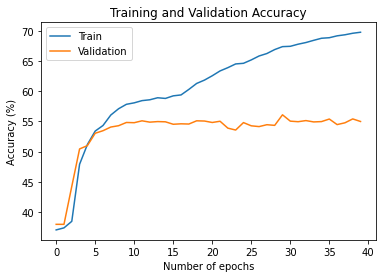

In [3]:
plt.title("Training and Validation Accuracy")
plt.plot(training_stats['Train_Acc'], label="Train")
plt.plot(training_stats['Val_Acc'], label="Validation")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

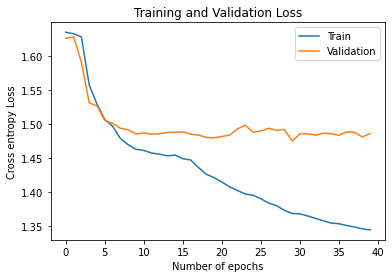

In [4]:
# Training/Validation Loss
plt.title("Training and Validation Loss")
plt.plot(training_stats['Train_Loss'], label="Train")
plt.plot(training_stats['Val_Loss'], label="Validation")
plt.xlabel("Number of epochs")
plt.ylabel("Cross entropy Loss")
plt.legend()
plt.show()
